# Figure of DICE metric
Seeing overlap trends of top hit brain regions with clusters

In [1]:
%run overlap_functions.ipynb
import seaborn as sns

In [2]:
# Loading the comprehensive overlap dataframe of brain regions and Jacobian
df_path = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/RAG2_neg_comp_overlap_anat.csv'
overlap_df = pd.read_csv(df_path, index_col = 'Unnamed: 0')

# Sorting the dataframe by DICE coeff and resetting the index
sorted_df = overlap_df.sort_values(by=['DICE_neg_jcb_anat'], ascending=False, na_position='last')
sorted_df.reset_index(drop=True, inplace=True)

# Choosing top hits until the overlap with jacobian reaches a threshold
threshold = 0.51
thresh_df = sorted_df[sorted_df['jac_overlap_ratio'].cumsum() < threshold]

print('Last index included to reach an overlap of {} with Jacobian is {}.'\
.format(threshold, thresh_df.shape[0]))

thresh_df.head()

Last index included to reach an overlap of 0.51 with Jacobian is 15.


,full_ant_index,structure,acronym,ish_id,ant_id,in_200_atlas,region_overlap_ratio,jac_overlap_ratio,DICE_neg_jcb_anat
0,1201,"""internal capsule""","""int""",566.0,6,True,0.810606,0.071716,0.131773
1,573,"""Caudoputamen""","""CP""",83.0,672,True,0.088754,0.097855,0.093083
2,610,"""Globus pallidus, external segment""","""GPe""",127.0,1022,True,0.643617,0.040550,0.076293
3,703,"""Reticular nucleus of the thalamus""","""RT""",315.0,262,True,0.586592,0.035188,0.066393
4,1188,"""arbor vitae""","""arb""",656.0,728,True,0.117841,0.035858,0.054985


In [3]:
'''
Brain regions to add:
1. "Primary visual area, layer 5", "VISp5" : 778
2. "Anterior cingulate area, dorsal part, layer 5", "ACAd5" : 1015
3. "Dentate gyrus, granule cell layer", "DG-sg" : 632
4. "Locus ceruleus", "LC" : 147
5. "Substantia nigra, compact part", "SNc" : 374
'''
extra_acronyms_list = ["VISp5", "ACAd5", "DG-sg", "LC", "SNc"]
extra_antid_list = [778, 1015, 632, 147, 374]

In [29]:
# Sortment of Brain regions into groups
worse_ids_list = [672, 463, 507]
converge_ids_list = [6, 1022, 1009, 867, 976, 1031, 147, 374, 778, 632]
plateau_ids_list = [262, 728, 484682528, 718, 81, 1091, 1015]

In [30]:
def plot_regions_DICE(region_ids_list, cluster_path):
    '''
    Plotting DICE score for brain regions over cluster numbers.
    
    Args:        
        region_ids_list: list
            List of brain region IDs to visualize.
        
        cluster_path: str
            The path to the cluster file.
    
    Returns:
        plot
    '''
    
    # List of K values
    number_range = list(range(1,50))
    ext_range = list(range(50,551,50))
    last_number = 594
    number_range.extend(ext_range)
    number_range.append(last_number)

    # Number of values in the range
    len_range = len(number_range)

    # Loading the anatomy file
    ant_file = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/allen_annot200.nii'
    ant_vec = nifti_to_array(ant_file)

    for count, ID in enumerate(region_ids_list):
        # Selecting a brain region
        region_ID = [ID]

        # Creating an array to store overlap ratios
        score_arr = np.zeros((last_number, len_range))

        # Looping over different clusters
        for i, n_clusters in enumerate(number_range):
            # Inputting path to the cluster file
            cluster_file = cluster_path+str(n_clusters)+'_clusters.npy'
            cluster_vec = np.load(cluster_file)
            cluster_ids = list(range(n_clusters))

            # Computing the overlap for the cluster
            overlap_list = overlap_function(base_arr = ant_vec, input_arr = cluster_vec,\
            base_ids_list = region_ID, input_ids_list = cluster_ids)

            # Adding the overlap list to the array
            score_arr[:n_clusters, i] = np.array(overlap_list)

        # Adding the array to the dictionary
        worse_score_dict[count] = score_arr
    
    # Setting the figure size
    plt.rcParams["figure.figsize"] = (7,5)

    # Initiating the plots
    fig, ax = plt.subplots()

    # Iterating over dictionary items
    for i, (j, score_arr) in enumerate(worse_score_dict.items()):

        # List of max overlap from each column
        max_ratio_list = []

        for z in range(len_range):
            max_ratio = np.amax(score_arr[:,z])
            max_ratio_list.append(max_ratio)

        # Defining x and y
        x = number_range
        y = max_ratio_list

        # print('Maximum ratio is {} for {} clusters.\n'.format(max(y), y.index(max(y))+1))

        # Plotting the ratios
        ax.plot(x, y)

    # Setting the grid style
    sns.set(style = "darkgrid")

    # Manual set of grid values and labels
    plt.xscale('log')
    x_values = [1,10,25,50,100,200,300,400,500,594]
    ax.set_xticks(x_values)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)

    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("Number of K-means clusters", fontsize = 16)
    plt.ylabel("DICE coefficient", fontsize = 16)
    plt.title("Maximum DICE coefficient", fontsize = 16)
    plt.legend(['RegionID_'+str(ID) for ID in region_ids_list], fontsize = 10)

    # Visualizing
    plt.show()

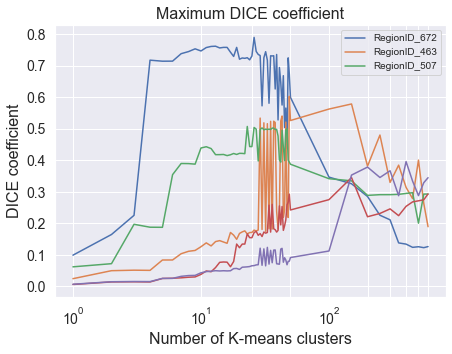

In [31]:
cluster_path = '/data/bioprotean/ABA/KernelPCA/rbf/labels_rc/'
plot_regions_DICE(worse_ids_list, cluster_path)

# For RBF kernel

**Worseners**

In [19]:
'''
Worseners!
'''
# Trying to make a list of brain region ant IDs (some from dataframe, some from manual choice)
# List of brain region numbers from dataframe to include
regions_list = [1,10,14]
region_ids_list = []

# These IDs are from manual choice
extra_region_ids = [778, 632]

# Creating a dictionary to store score arrays
worse_score_dict = {}

# Making a full list of IDs
for id in regions_list:
    region_ID = thresh_df['ant_id'][id]
    region_ids_list.append(region_ID)

# Adding to the IDs list
region_ids_list.extend(extra_region_ids)

# List of K values
number_range = list(range(1,50))
ext_range = list(range(50,551,50))
last_number = 594
number_range.extend(ext_range)
number_range.append(last_number)

# Number of values in the range
len_range = len(number_range)


# Loading the anatomy file
ant_file = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/allen_annot200.nii'
ant_vec = nifti_to_array(ant_file)

for count, ID in enumerate(region_ids_list):
    # Selecting a brain region
    region_ID = [ID]

    # Creating an array to store overlap ratios
    score_arr = np.zeros((last_number, len_range))

    # Looping over different clusters
    for i, n_clusters in enumerate(number_range):
        # Inputting path to the cluster file
        cluster_file = '/data/bioprotean/ABA/KernelPCA/rbf/labels_rc/'+str(n_clusters)+'_clusters.npy'
        cluster_vec = np.load(cluster_file)
        cluster_ids = list(range(n_clusters))

        # Computing the overlap for the cluster
        overlap_list = overlap_function(base_arr = ant_vec, input_arr = cluster_vec,\
        base_ids_list = region_ID, input_ids_list = cluster_ids)

        # Adding the overlap list to the array
        score_arr[:n_clusters, i] = np.array(overlap_list)
    
    # Adding the array to the dictionary
    worse_score_dict[count] = score_arr

[672, 463, 507, 778, 632]

Maximum ratio is 0.7898983861326958 for 26 clusters.

Maximum ratio is 0.602974828375286 for 49 clusters.

Maximum ratio is 0.5074520936834634 for 23 clusters.

Maximum ratio is 0.34527687296416937 for 52 clusters.

Maximum ratio is 0.39600665557404324 for 57 clusters.



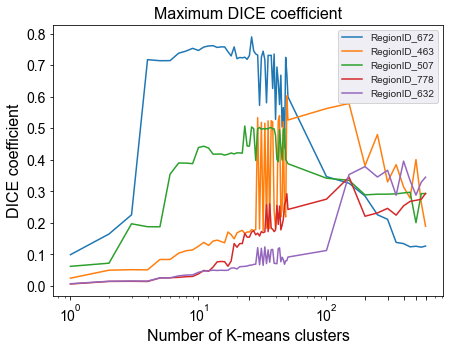

In [5]:
'''
Plotting the highest value in each experiment.
'''

# Setting the figure size
plt.rcParams["figure.figsize"] = (7,5)

# Initiating the plots
fig, ax = plt.subplots()

# Iterating over dictionary items
for i, (j, score_arr) in enumerate(worse_score_dict.items()):
    
    # List of max overlap from each column
    max_ratio_list = []

    for z in range(len_range):
        max_ratio = np.amax(score_arr[:,z])
        max_ratio_list.append(max_ratio)

    # Defining x and y
    x = number_range
    y = max_ratio_list

    print('Maximum ratio is {} for {} clusters.\n'.format(max(y), y.index(max(y))+1))

    # Plotting the ratios
    ax.plot(x, y)

# Setting the grid style
sns.set(style = "darkgrid")

# Manual set of grid values and labels
plt.xscale('log')
x_values = [1,10,25,50,100,200,300,400,500,594]
ax.set_xticks(x_values)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of K-means clusters", fontsize = 16)
plt.ylabel("DICE coefficient", fontsize = 16)
plt.title("Maximum DICE coefficient", fontsize = 16)
plt.legend(['RegionID_'+str(ID) for ID in region_ids_list], fontsize = 10)

# Visualizing
plt.show()

**Convergers**

In [20]:
'''
Convergers!
'''
# Trying to make a list of brain region ant IDs (some from dataframe, some from manual choice)
# List of brain region numbers from dataframe to include
regions_list = [0,2,5,9,11,12]
region_ids_list = []

# These IDs are from manual choice
extra_region_ids = [147, 374]

# Creating a dictionary to store score arrays
converge_score_dict = {}


# Making a full list of IDs
for id in regions_list:
    region_ID = thresh_df['ant_id'][id]
    region_ids_list.append(region_ID)

# Adding to the IDs list
region_ids_list.extend(extra_region_ids)

region_ids_list
# # List of K values
# number_range = list(range(1,50))
# ext_range = list(range(50,551,50))
# last_number = 594
# number_range.extend(ext_range)
# number_range.append(last_number)

# # Number of values in the range
# len_range = len(number_range)


# # Loading the anatomy file
# ant_file = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/allen_annot200.nii'
# ant_vec = nifti_to_array(ant_file)

# for count, ID in enumerate(region_ids_list):
#     # Selecting a brain region
#     region_ID = [ID]

#     # Creating an array to store overlap ratios
#     score_arr = np.zeros((last_number, len_range))

#     # Looping over different clusters
#     for i, n_clusters in enumerate(number_range):
#         # Inputting path to the cluster file
#         cluster_file = '/data/bioprotean/ABA/KernelPCA/rbf/labels_rc/'+str(n_clusters)+'_clusters.npy'
#         cluster_vec = np.load(cluster_file)
#         cluster_ids = list(range(n_clusters))

#         # Computing the overlap for the cluster
#         overlap_list = overlap_function(base_arr = ant_vec, input_arr = cluster_vec,\
#         base_ids_list = region_ID, input_ids_list = cluster_ids)

#         # Adding the overlap list to the array
#         score_arr[:n_clusters, i] = np.array(overlap_list)
    
#     # Adding the array to the dictionary
#     converge_score_dict[count] = score_arr

[6, 1022, 1009, 867, 976, 1031, 147, 374]

Maximum ratio is 0.453416149068323 for 56 clusters.

Maximum ratio is 0.5808080808080808 for 60 clusters.

Maximum ratio is 0.22444889779559118 for 59 clusters.

Maximum ratio is 0.42105263157894735 for 60 clusters.

Maximum ratio is 0.5799457994579946 for 58 clusters.

Maximum ratio is 0.3048780487804878 for 60 clusters.

Maximum ratio is 0.07228915662650602 for 60 clusters.

Maximum ratio is 0.17647058823529413 for 58 clusters.



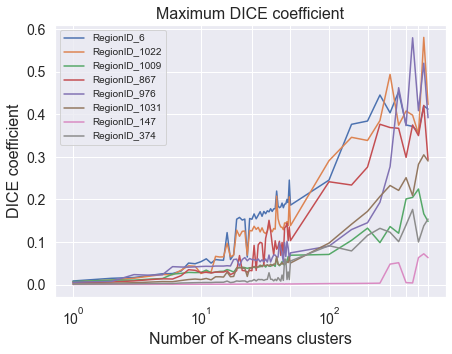

In [7]:
'''
Plotting the highest value in each experiment.
'''

# Setting the figure size
plt.rcParams["figure.figsize"] = (7,5)

# Initiating the plots
fig, ax = plt.subplots()

# Iterating over dictionary items
for i, (j, score_arr) in enumerate(converge_score_dict.items()):
    
    # List of max overlap from each column
    max_ratio_list = []

    for z in range(len_range):
        max_ratio = np.amax(score_arr[:,z])
        max_ratio_list.append(max_ratio)

    # Defining x and y
    x = number_range
    y = max_ratio_list

    print('Maximum ratio is {} for {} clusters.\n'.format(max(y), y.index(max(y))+1))

    # Plotting the ratios
    ax.plot(x, y)

# Setting the grid style
sns.set(style = "darkgrid")

# Manual set of grid values and labels
plt.xscale('log')
x_values = [1,10,25,50,100,200,300,400,500,594]
ax.set_xticks(x_values)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of K-means clusters", fontsize = 16)
plt.ylabel("DICE coefficient", fontsize = 16)
plt.title("Maximum DICE coefficient", fontsize = 16)
plt.legend(['RegionID_'+str(ID) for ID in region_ids_list], fontsize = 10)

# Visualizing
plt.show()

In [21]:
'''
Plateau trend!
'''
# Trying to make a list of brain region ant IDs (some from dataframe, some from manual choice)
# List of brain region numbers from dataframe to include
regions_list = [3,4,6,7,8,13]
region_ids_list = []

# These IDs are from manual choice
extra_region_ids = [1015]

# Creating a dictionary to store score arrays
plateau_score_dict = {}


# Making a full list of IDs
for id in regions_list:
    region_ID = thresh_df['ant_id'][id]
    region_ids_list.append(region_ID)

# Adding to the IDs list
region_ids_list.extend(extra_region_ids)

region_ids_list
# # List of K values
# number_range = list(range(1,50))
# ext_range = list(range(50,551,50))
# last_number = 594
# number_range.extend(ext_range)
# number_range.append(last_number)

# # Number of values in the range
# len_range = len(number_range)


# # Loading the anatomy file
# ant_file = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/allen_annot200.nii'
# ant_vec = nifti_to_array(ant_file)

# for count, ID in enumerate(region_ids_list):
#     # Selecting a brain region
#     region_ID = [ID]

#     # Creating an array to store overlap ratios
#     score_arr = np.zeros((last_number, len_range))

#     # Looping over different clusters
#     for i, n_clusters in enumerate(number_range):
#         # Inputting path to the cluster file
#         cluster_file = '/data/bioprotean/ABA/KernelPCA/rbf/labels_rc/'+str(n_clusters)+'_clusters.npy'
#         cluster_vec = np.load(cluster_file)
#         cluster_ids = list(range(n_clusters))

#         # Computing the overlap for the cluster
#         overlap_list = overlap_function(base_arr = ant_vec, input_arr = cluster_vec,\
#         base_ids_list = region_ID, input_ids_list = cluster_ids)

#         # Adding the overlap list to the array
#         score_arr[:n_clusters, i] = np.array(overlap_list)
    
#     # Adding the array to the dictionary
#     plateau_score_dict[count] = score_arr

[262, 728, 484682528, 718, 81, 1091, 1015]

Maximum ratio is 0.7066381156316917 for 54 clusters.

Maximum ratio is 0.4498432601880878 for 54 clusters.

Maximum ratio is 0.29260450160771706 for 52 clusters.

Maximum ratio is 0.29646017699115046 for 52 clusters.

Maximum ratio is 0.4119106699751861 for 60 clusters.

Maximum ratio is 0.3863080684596577 for 41 clusters.

Maximum ratio is 0.20817843866171004 for 58 clusters.



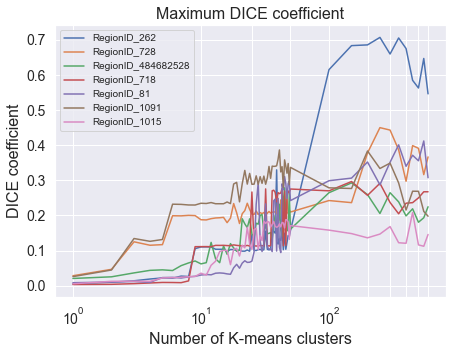

In [14]:
'''
Plotting the highest value in each experiment.
'''

# Setting the figure size
plt.rcParams["figure.figsize"] = (7,5)

# Initiating the plots
fig, ax = plt.subplots()

# Iterating over dictionary items
for i, (j, score_arr) in enumerate(plateau_score_dict.items()):
    
    # List of max overlap from each column
    max_ratio_list = []

    for z in range(len_range):
        max_ratio = np.amax(score_arr[:,z])
        max_ratio_list.append(max_ratio)

    # Defining x and y
    x = number_range
    y = max_ratio_list

    print('Maximum ratio is {} for {} clusters.\n'.format(max(y), y.index(max(y))+1))

    # Plotting the ratios
    ax.plot(x, y)

# Setting the grid style
sns.set(style = "darkgrid")

# Manual set of grid values and labels
plt.xscale('log')
x_values = [1,10,25,50,100,200,300,400,500,594]
ax.set_xticks(x_values)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of K-means clusters", fontsize = 16)
plt.ylabel("DICE coefficient", fontsize = 16)
plt.title("Maximum DICE coefficient", fontsize = 16)
plt.legend(['RegionID_'+str(ID) for ID in region_ids_list], fontsize = 10)

# Visualizing
plt.show()

# For Poly2 kernel

**Worseners**

In [15]:
'''
Worseners!
'''
# Trying to make a list of brain region ant IDs (some from dataframe, some from manual choice)
# List of brain region numbers from dataframe to include
regions_list = [1,10,14]
region_ids_list = []

# These IDs are from manual choice
extra_region_ids = [778, 632]

# Creating a dictionary to store score arrays
worse_score_dict = {}

# Making a full list of IDs
for id in regions_list:
    region_ID = thresh_df['ant_id'][id]
    region_ids_list.append(region_ID)

# Adding to the IDs list
region_ids_list.extend(extra_region_ids)


# List of K values
number_range = list(range(1,50))
ext_range = list(range(50,551,50))
last_number = 594
number_range.extend(ext_range)
number_range.append(last_number)

# Number of values in the range
len_range = len(number_range)


# Loading the anatomy file
ant_file = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/allen_annot200.nii'
ant_vec = nifti_to_array(ant_file)

for count, ID in enumerate(region_ids_list):
    # Selecting a brain region
    region_ID = [ID]

    # Creating an array to store overlap ratios
    score_arr = np.zeros((last_number, len_range))
    
    # Looping over different clusters
    for i, n_clusters in enumerate(number_range):
        # Inputting path to the cluster file
        cluster_file = '/data/bioprotean/ABA/KernelPCA/poly2/labels_rc/'+str(n_clusters)+'_clusters.npy'
        cluster_vec = np.load(cluster_file)
        cluster_ids = list(range(n_clusters))

        # Computing the overlap for the cluster
        overlap_list = overlap_function(base_arr = ant_vec, input_arr = cluster_vec,\
        base_ids_list = region_ID, input_ids_list = cluster_ids)

        # Adding the overlap list to the array
        score_arr[:n_clusters, i] = np.array(overlap_list)
    
    # Adding the array to the dictionary
    worse_score_dict[count] = score_arr

Maximum ratio is 0.7640918580375783 for 23 clusters.

Maximum ratio is 0.6011560693641619 for 44 clusters.

Maximum ratio is 0.49618684461391804 for 46 clusters.

Maximum ratio is 0.29476584022038566 for 52 clusters.

Maximum ratio is 0.3552397868561279 for 40 clusters.



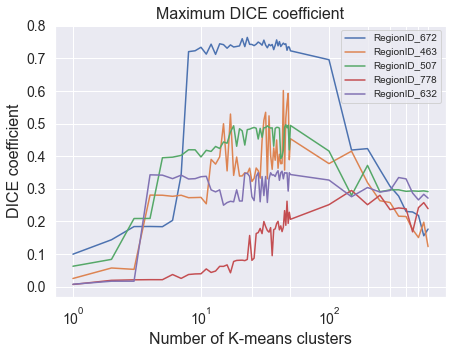

In [16]:
'''
Plotting the highest value in each experiment.
'''

# Setting the figure size
plt.rcParams["figure.figsize"] = (7,5)

# Initiating the plots
fig, ax = plt.subplots()

# Iterating over dictionary items
for i, (j, score_arr) in enumerate(worse_score_dict.items()):
    
    # List of max overlap from each column
    max_ratio_list = []

    for z in range(len_range):
        max_ratio = np.amax(score_arr[:,z])
        max_ratio_list.append(max_ratio)

    # Defining x and y
    x = number_range
    y = max_ratio_list

    print('Maximum ratio is {} for {} clusters.\n'.format(max(y), y.index(max(y))+1))

    # Plotting the ratios
    ax.plot(x, y)

# Setting the grid style
sns.set(style = "darkgrid")

# Manual set of grid values and labels
plt.xscale('log')
x_values = [1,10,25,50,100,200,300,400,500,594]
ax.set_xticks(x_values)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of K-means clusters", fontsize = 16)
plt.ylabel("DICE coefficient", fontsize = 16)
plt.title("Maximum DICE coefficient", fontsize = 16)
plt.legend(['RegionID_'+str(ID) for ID in region_ids_list], fontsize = 10)

# Visualizing
plt.show()

**Convergers**

In [18]:
'''
Convergers!
'''
# Trying to make a list of brain region ant IDs (some from dataframe, some from manual choice)
# List of brain region numbers from dataframe to include
regions_list = [0,2,5,9,11,12]
region_ids_list = []

# These IDs are from manual choice
extra_region_ids = [147, 374]

# Creating a dictionary to store score arrays
converge_score_dict = {}


# Making a full list of IDs
for id in regions_list:
    region_ID = thresh_df['ant_id'][id]
    region_ids_list.append(region_ID)

# Adding to the IDs list
region_ids_list.extend(extra_region_ids)


# List of K values
number_range = list(range(1,50))
ext_range = list(range(50,551,50))
last_number = 594
number_range.extend(ext_range)
number_range.append(last_number)

# Number of values in the range
len_range = len(number_range)


# Loading the anatomy file
ant_file = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/allen_annot200.nii'
ant_vec = nifti_to_array(ant_file)

for count, ID in enumerate(region_ids_list):
    # Selecting a brain region
    region_ID = [ID]

    # Creating an array to store overlap ratios
    score_arr = np.zeros((last_number, len_range))

    # Looping over different clusters
    for i, n_clusters in enumerate(number_range):
        # Inputting path to the cluster file
        cluster_file = '/data/bioprotean/ABA/KernelPCA/poly2/labels_rc/'+str(n_clusters)+'_clusters.npy'
        cluster_vec = np.load(cluster_file)
        cluster_ids = list(range(n_clusters))

        # Computing the overlap for the cluster
        overlap_list = overlap_function(base_arr = ant_vec, input_arr = cluster_vec,\
        base_ids_list = region_ID, input_ids_list = cluster_ids)

        # Adding the overlap list to the array
        score_arr[:n_clusters, i] = np.array(overlap_list)
    
    # Adding the array to the dictionary
    converge_score_dict[count] = score_arr

In [ ]:
'''
Plotting the highest value in each experiment.
'''

# Setting the figure size
plt.rcParams["figure.figsize"] = (7,5)

# Initiating the plots
fig, ax = plt.subplots()

# Iterating over dictionary items
for i, (j, score_arr) in enumerate(converge_score_dict.items()):
    
    # List of max overlap from each column
    max_ratio_list = []

    for z in range(len_range):
        max_ratio = np.amax(score_arr[:,z])
        max_ratio_list.append(max_ratio)

    # Defining x and y
    x = number_range
    y = max_ratio_list

    print('Maximum ratio is {} for {} clusters.\n'.format(max(y), y.index(max(y))+1))

    # Plotting the ratios
    ax.plot(x, y)

# Setting the grid style
sns.set(style = "darkgrid")

# Manual set of grid values and labels
plt.xscale('log')
x_values = [1,10,25,50,100,200,300,400,500,594]
ax.set_xticks(x_values)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of K-means clusters", fontsize = 16)
plt.ylabel("DICE coefficient", fontsize = 16)
plt.title("Maximum DICE coefficient", fontsize = 16)
plt.legend(['RegionID_'+str(ID) for ID in region_ids_list], fontsize = 10)

# Visualizing
plt.show()

Maximum ratio is 0.7919014084507042 for 34 clusters.

Maximum ratio is 0.5287175452399685 for 39 clusters.

Maximum ratio is 0.4510026485054862 for 22 clusters.



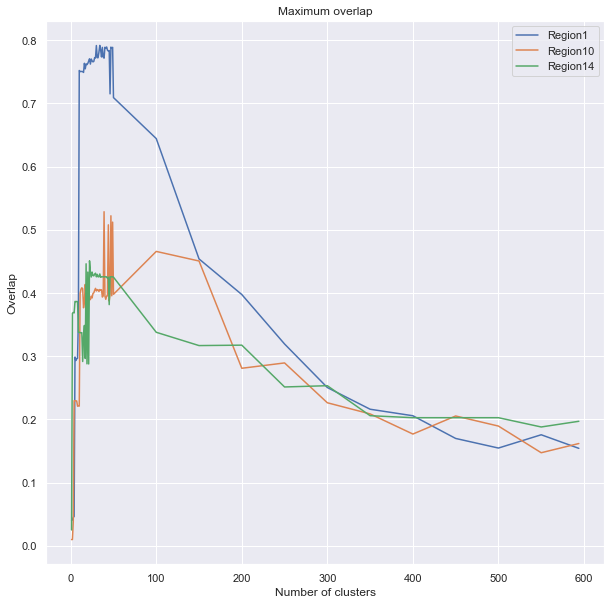

In [65]:
'''
Falling trend!
'''
# Number of values in the range
len_range = len(number_range)

# List of K values
number_range = list(range(1,50))
ext_range = list(range(50,551,50))
last_number = 594
number_range.extend(ext_range)
number_range.append(last_number)

# List of brain region numbers from dataframe to include
regions_list = [1,10,14]

# Loading the anatomy file
ant_file = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/allen_annot200.nii'
ant_vec = nifti_to_array(ant_file)

for i in regions_list:
    # Selecting a brain region
    region_number = i
    region_ID = [thresh_df['ant_id'][region_number]]

    # Creating an array to store overlap ratios
    score_arr = np.zeros((last_number, len_range))

    # Looping over different clusters
    for i, n_clusters in enumerate(number_range):
        # Inputting path to the cluster file
        cluster_file = '/data/bioprotean/ABA/DLSC/pos_std/Kmeans_labels/'+str(n_clusters)+'_clusters.npy'
        cluster_vec = np.load(cluster_file)
        cluster_ids = list(range(n_clusters))

        # Computing the overlap for the cluster
        overlap_list = overlap_function(base_arr = ant_vec, input_arr = cluster_vec,\
        base_ids_list = region_ID, input_ids_list = cluster_ids)

        # Adding the overlap list to the array
        score_arr[:n_clusters, i] = np.array(overlap_list)

    # Converting the array to a dataframe
    output_0_df = pd.DataFrame(score_arr, columns = [str(i)+'_clusters' for i in number_range])
    output_0_df['cluster_ID'] = range(last_number)
    output_0_df.set_index('cluster_ID', inplace = True)
    
    
    '''
    Plotting the highest value in each experiment.
    '''
    # List of max overlap from each column
    max_ratio_list = []

    for i, value in enumerate(output_0_df.columns.tolist()):
        max_ratio = output_0_df.iloc[:,i].max()
        max_ratio_list.append(max_ratio)

    # Defining x and y
    x = number_range
    y = max_ratio_list

    print('Maximum ratio is {} for {} clusters.\n'.format(max(y), y.index(max(y))+1))

    # Plotting the ratios
    plt.plot(x, y)

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of clusters")
plt.ylabel("Overlap")
# plt.xscale('log')
plt.title("Maximum overlap")
plt.legend(['Region'+str(i) for i in regions_list])
# Setting the figure size
plt.rcParams["figure.figsize"] = (10,10)

# To load the display window
sns.set(style = "darkgrid")
plt.show()

Maximum ratio is 0.39183673469387753 for 58 clusters.

Maximum ratio is 0.5892116182572614 for 60 clusters.

Maximum ratio is 0.2144638403990025 for 59 clusters.

Maximum ratio is 0.37320574162679426 for 55 clusters.

Maximum ratio is 0.31840796019900497 for 58 clusters.

Maximum ratio is 0.2833333333333333 for 61 clusters.



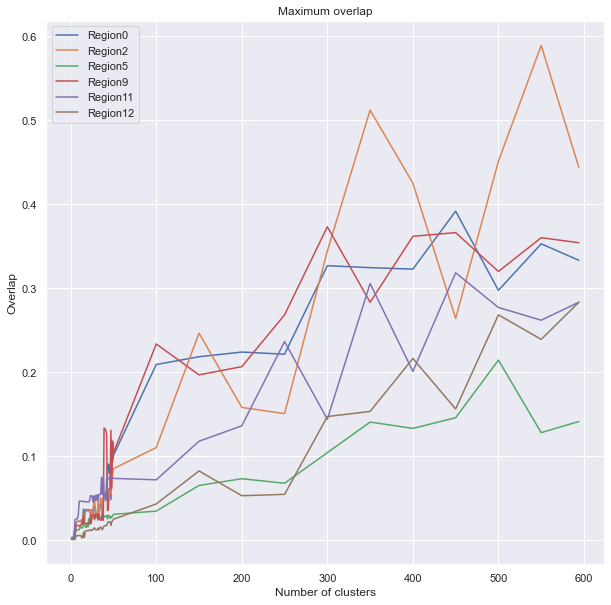

In [68]:
'''
Increasing trend!
'''
# List of brain region numbers from dataframe to include
regions_list = [0,2,5,9,11,12]

# List of K values
number_range = list(range(1,50))
ext_range = list(range(50,551,50))
last_number = 594
number_range.extend(ext_range)
number_range.append(last_number)

# Loading the anatomy file
ant_file = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/allen_annot200.nii'
ant_vec = nifti_to_array(ant_file)

for i in regions_list:
    # Selecting a brain region
    region_number = i
    region_ID = [thresh_df['ant_id'][region_number]]

    # Creating an array to store overlap ratios
    score_arr = np.zeros((last_number, len_range))

    # Looping over different clusters
    for i, n_clusters in enumerate(number_range):
        # Inputting path to the cluster file
        cluster_file = '/data/bioprotean/ABA/DLSC/pos_std/Kmeans_labels/'+str(n_clusters)+'_clusters.npy'
        cluster_vec = np.load(cluster_file)
        cluster_ids = list(range(n_clusters))

        # Computing the overlap for the cluster
        overlap_list = overlap_function(base_arr = ant_vec, input_arr = cluster_vec,\
        base_ids_list = region_ID, input_ids_list = cluster_ids)

        # Adding the overlap list to the array
        score_arr[:n_clusters, i] = np.array(overlap_list)

    # Converting the array to a dataframe
    output_0_df = pd.DataFrame(score_arr, columns = [str(i)+'_clusters' for i in number_range])
    output_0_df['cluster_ID'] = range(last_number)
    output_0_df.set_index('cluster_ID', inplace = True)
    
    
    '''
    Plotting the highest value in each experiment.
    '''
    # List of max overlap from each column
    max_ratio_list = []

    for i, value in enumerate(output_0_df.columns.tolist()):
        max_ratio = output_0_df.iloc[:,i].max()
        max_ratio_list.append(max_ratio)

    # Defining x and y
    x = number_range
    y = max_ratio_list

    print('Maximum ratio is {} for {} clusters.\n'.format(max(y), y.index(max(y))+1))

    # Plotting the ratios
    plt.plot(x, y)

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of clusters")
plt.ylabel("Overlap")
plt.title("Maximum overlap")
plt.legend(['Region'+str(i) for i in regions_list])
# Setting the figure size
plt.rcParams["figure.figsize"] = (10,10)

# To load the display window
sns.set(style = "darkgrid")
plt.show()

Maximum ratio is 0.6254980079681275 for 54 clusters.

Maximum ratio is 0.3848531684698609 for 59 clusters.

Maximum ratio is 0.32561851556264965 for 54 clusters.

Maximum ratio is 0.3983739837398374 for 58 clusters.

Maximum ratio is 0.34294385432473445 for 52 clusters.

Maximum ratio is 0.44668587896253603 for 57 clusters.



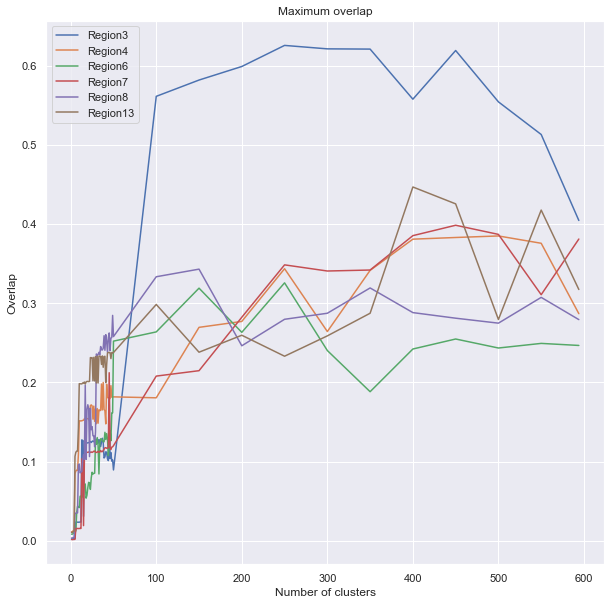

In [69]:
'''
Plateau trend!
'''
# List of brain region numbers from dataframe to include
regions_list = [3,4,6,7,8,13]

# List of K values
number_range = list(range(1,50))
ext_range = list(range(50,551,50))
last_number = 594
number_range.extend(ext_range)
number_range.append(last_number)

# Loading the anatomy file
ant_file = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/allen_annot200.nii'
ant_vec = nifti_to_array(ant_file)

for i in regions_list:
    # Selecting a brain region
    region_number = i
    region_ID = [thresh_df['ant_id'][region_number]]

    # Creating an array to store overlap ratios
    score_arr = np.zeros((last_number, len_range))

    # Looping over different clusters
    for i, n_clusters in enumerate(number_range):
        # Inputting path to the cluster file
        cluster_file = '/data/bioprotean/ABA/DLSC/pos_std/Kmeans_labels/'+str(n_clusters)+'_clusters.npy'
        cluster_vec = np.load(cluster_file)
        cluster_ids = list(range(n_clusters))

        # Computing the overlap for the cluster
        overlap_list = overlap_function(base_arr = ant_vec, input_arr = cluster_vec,\
        base_ids_list = region_ID, input_ids_list = cluster_ids)

        # Adding the overlap list to the array
        score_arr[:n_clusters, i] = np.array(overlap_list)

    # Converting the array to a dataframe
    output_0_df = pd.DataFrame(score_arr, columns = [str(i)+'_clusters' for i in number_range])
    output_0_df['cluster_ID'] = range(last_number)
    output_0_df.set_index('cluster_ID', inplace = True)
    
    
    '''
    Plotting the highest value in each experiment.
    '''
    # List of max overlap from each column
    max_ratio_list = []

    for i, value in enumerate(output_0_df.columns.tolist()):
        max_ratio = output_0_df.iloc[:,i].max()
        max_ratio_list.append(max_ratio)

    # Defining x and y
    x = number_range
    y = max_ratio_list

    print('Maximum ratio is {} for {} clusters.\n'.format(max(y), y.index(max(y))+1))

    # Plotting the ratios
    plt.plot(x, y)

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of clusters")
plt.ylabel("Overlap")
plt.title("Maximum overlap")
plt.grid(True)
plt.legend(['Region'+str(i) for i in regions_list])
# Setting the figure size
plt.rcParams["figure.figsize"] = (10,10)

# To load the display window
sns.set(style = "darkgrid")
plt.show()